Initial setup

In [1]:
import wosis
import pandas as pd
import metaknowledge as mk

In [2]:
# Helper functions for plotting
import wosis.analysis.plotting as wos_plot

# Analysis and search functions
from wosis.analysis import (preview_matches, search_records, keyword_matches, 
                            find_pubs_by_authors, preview_matches_by_keyword, get_unique_kw_titles,
                            remove_by_journals, remove_by_title)

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# This just helps make the plots look nicer
sns.set_style('darkgrid')
sns.set_context('paper', font_scale=2.0)

In [3]:
# Read in data from temporary cache file
query_id = "756d39801152fe5f5f4ad3a3df9b6a30"
RC = mk.RecordCollection("tmp/{}.txt".format(query_id))

expected_num_records = 15754
num_records = len(RC)

assert num_records == expected_num_records, \
    "Mismatch in number of records - expected {}, got {}".format(expected_num_records, num_records)

print("Corpora consists of", num_records, "Publications")

Corpora consists of 15754 Publications


In [4]:
corpora_df = wosis.rc_to_df(RC)

corpora_df, removed_pubs = wosis.constrain.remove_empty_DOIs(corpora_df)

Removing 1799 records with no DOIs


In [5]:
# Hiding keywords and abstract for tutorial (WoS-owned IP)
hide_columns = ['DE', 'abstract', 'keywords', 'DOI', 'id', 'kws']

In [6]:
# Checking if expected paper is in corpora
corpora_df.loc[corpora_df['DOI'] == '10.1016/j.jocs.2015.08.008', :]

,AU,DE,DOI,SO,abstract,copyright,id,keywords,title,year
4490,"Feinberg, Jonathan|Langtangen, Hans Petter",uncertainty quantification|polynomial chaos ex...,10.1016/j.jocs.2015.08.008,JOURNAL OF COMPUTATIONAL SCIENCE,"The paper describes the philosophy, design, fu...",Published by Elsevier B.V.,WOS:000367774700005,,Chaospy: An open source tool for designing met...,2015


In [7]:
# Create a new metaknowledge collection
filtered_corpora = wosis.extract_recs(corpora_df.loc[:, 'id'], RC, name='Filtered Corpora')

<hr>

Run topic model

In [8]:
from wosis.analysis import find_topics

filtered_corpora_df = wosis.rc_to_df(filtered_corpora)
topic_results = find_topics(filtered_corpora_df, num_topics=5)

Topic 1: water model soil flow river parameters sensitivity groundwater runoff data
Topic 2: optimization design method shape topology sensitivity problem element finite structural
Topic 3: energy life cycle environmental emissions production waste assessment lca impact
Topic 4: uncertainty model models stochastic data analysis parameter parameters method bayesian
Topic 5: risk exposure assessment health cancer risks human flood probabilistic dose


In [9]:
topic_pubs = {
    'model': topic_results.get_topic_by_id(1),
    # 'UA': topic_results.get_topic_by_id(8)
    # 'SA': topic_results.get_topic_by_id(20)
}

# len(topic_pubs['model']), len(topic_pubs['UA'])
len(topic_pubs['model'])

4773

In [10]:
# find paper of interest - see if it's still in the corpora
for i in range(1,26):
    topic_set = topic_results.get_topic_by_id(i)
    
    topic_recs = wosis.extract_recs(topic_set.loc[:, 'id'], RC, 'Topic of Interest')
    tmp_df = pd.DataFrame(topic_recs.forNLP(extraColumns=['DOI']))

    if len(tmp_df.loc[tmp_df["DOI"] == '10.1016/j.jocs.2015.08.008', :]) > 0:
        print("Found paper in topic", i)
        break

Found paper in topic 4


In [11]:
# topic_set.loc[:, ~topic_set.columns.isin(hide_columns)].head(10)

In [12]:
uc_model_topic = topic_results.get_topic_by_id(4)
uc_model_rc = wosis.extract_recs(uc_model_topic.loc[:, 'id'], RC, 'Topic of Interest')

In [13]:
ua_topic_df = wosis.rc_to_df(uc_model_rc)
ua_topic_df.loc[ua_topic_df["DOI"] == '10.1016/j.jocs.2015.08.008', :]

,AU,DE,DOI,SO,abstract,copyright,id,keywords,title,year
552,"Feinberg, Jonathan|Langtangen, Hans Petter",uncertainty quantification|polynomial chaos ex...,10.1016/j.jocs.2015.08.008,JOURNAL OF COMPUTATIONAL SCIENCE,"The paper describes the philosophy, design, fu...",Published by Elsevier B.V.,WOS:000367774700005,,Chaospy: An open source tool for designing met...,2015


<hr>

Plot journal trend of topic 1, see top publications by citation

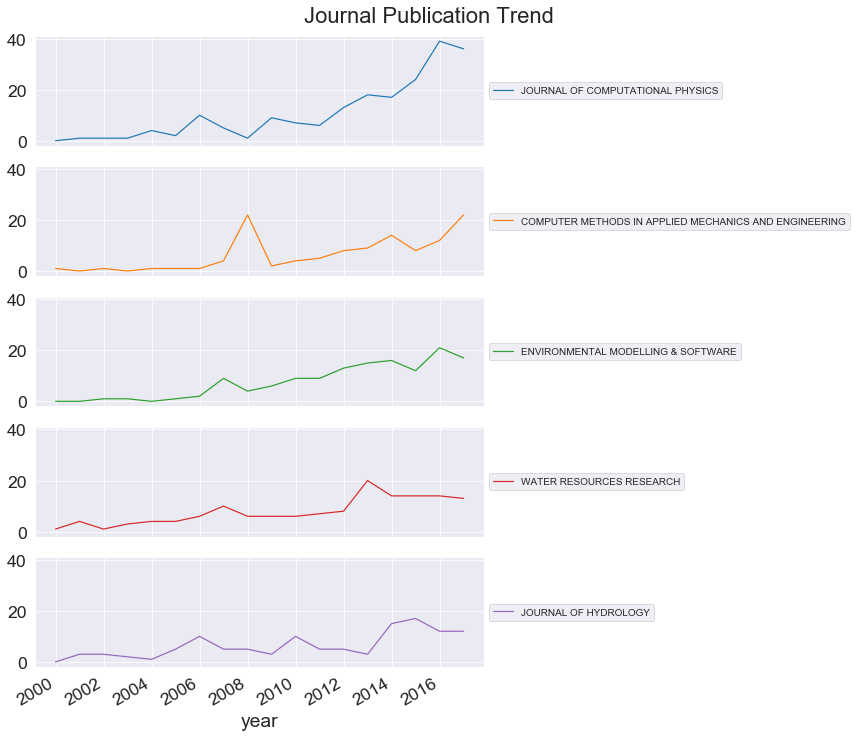

In [14]:
wos_plot.plot_journal_pub_trend(uc_model_rc, top_n=5, save_plot_fn='figs/uc_model_journal_pub_trend.png')

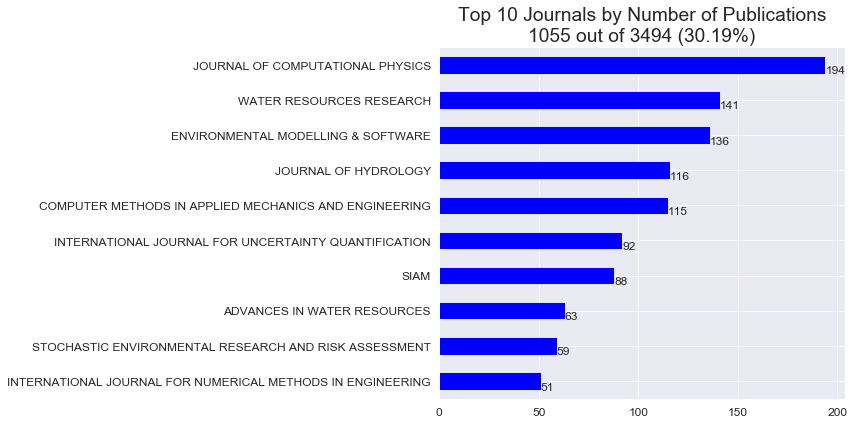

In [15]:
wos_plot.plot_pubs_per_journal(uc_model_rc, top_n=10, annotate=True, show_stats=True, save_plot_fn='figs/uc_model_journal_pubs.png')

In [16]:
# These are the papers cited within the corpora
wosis.analysis.pub_citations(uc_model_rc).head()
#ideas: could take first 1000 by citation number, but higher citations would favour older papers.  Taking by year?
#or simply choose first 1000 matches?

,Citations
Publication,
"Beven, K, 2000, The use of generalised likelihood measures for uncertainty estimation in high-order models of environmental systems, NONLINEAR AND NONSTATIONARY SIGNAL PROCESSING, 115, 400154",670
"Xiu, DB, 2005, High-order collocation methods for differential equations with random inputs, SIAM JOURNAL ON SCIENTIFIC COMPUTING, 27, 1118, 65700615",659
"Saltelli, A, 2000, Sensitivity Analysis, 287467390",591
"Ghanem, R, 1991, Stochastic Finite Elements: A Spectral Approach, 277481739",467
"Saltelli, A., 2004, Sensitivity Analysis in Practice, A guide to Assesing Scientific Models, 287480276",344


In [17]:
uc_model_doi = wosis.link_to_pub(uc_model_rc)  # Creates a new column called 'DOI link'
uc_model_doi.loc[:, ~uc_model_doi.columns.isin(hide_columns)].head()

,AU,SO,title,year,DOI link
0,"Wei, Xiaochen|Li, Qi|Li, Xiaying|Sun, Yankun",NATURAL HAZARDS,Impact indicators for caprock integrity and in...,2016,https://dx.doi.org/10.1007/s11069-015-2063-5
1,"van den Bos, L. M. M.|Koren, B.|Dwight, R. P.",JOURNAL OF COMPUTATIONAL PHYSICS,Non-intrusive uncertainty quantification using...,2017,https://dx.doi.org/10.1016/j.jcp.2016.12.011
2,"Suwantawat, P|Premrudeepreechacharn, S",PROCEEDINGS OF THE 2004 IEEE INTERNATIONAL CON...,Reliability evaluation of substation delivery ...,2004,https://dx.doi.org/10.1109/DRPT.2004.1338055
3,"Tsilanizara, A.|Gilardi, N.|Huynh, T. D.|Jouan...",SNA + MC 2013 - JOINT INTERNATIONAL CONFERENCE...,Probabilistic approach for decay heat uncertai...,2014,https://dx.doi.org/10.1015/snamc/201402409
4,"Xu, Yue-Ping|Tung, Yeou-Koung",WATER RESOURCES MANAGEMENT,Decision-making in water management under unce...,2008,https://dx.doi.org/10.1007/s11269-007-9176-x


<hr>

Further analysis of topic model results: <br>
- Search papers in topic of interest by keyword
- Run criteria search on topic of interest
- Want to list these papers into a table to export to csv, this was formerly achieved in an old notebook
- Plot trend in criteria matches
- Want to save the final plot to file, but it doesn't use the standard wos_plot function

In [18]:
# find papers of interest - having certain keywords

opt_topic = topic_results.get_topic_by_id(2)

opt_rc = wosis.extract_recs(opt_topic.loc[:, 'id'], RC, 'Topic of Interest')


# need this next command to be keywords including ... eg uncertainty

# optimization topic, uncertainty keyword
opt_uc_rc = wosis.search_records(opt_rc, "uncertainty", threshold=95.0)
opt_uc_df = wosis.rc_to_df(opt_uc_rc)

opt_uc_df.head()

# some more ideas: filter topic 2 by papers with sensitivity in title/keywords/abstract to decrease size of dataset.
# might work for topic 1 as well?

,AU,DE,DOI,SO,abstract,copyright,id,keywords,title,year
0,"Schueller, G. I.|Jensen, H. A.",uncertainty|optimization|robustness|reliabilit...,10.1016/j.cma.2008.05.004,COMPUTER METHODS IN APPLIED MECHANICS AND ENGI...,This article presents a brief survey on some o...,(C) 2008 Elsevier B.V. All rights reserved.,WOS:000261249700002,RELIABILITY-BASED OPTIMIZATION|LINEAR DYNAMICA...,Computational methods in optimization consider...,2008
1,"Liu, Wing Kam|Siad, Larbi|Tian, Rong|Lee, Sang...","bayesian|calibration, damage, dns, ducule, fai...",10.1002/nme.2578,INTERNATIONAL JOURNAL FOR NUMERICAL METHODS IN...,New technological advances today allow for a r...,"Copyright (C) 2009 John Wiley & Sons, Ltd",WOS:000271559400013,REPRESENTATIVE VOLUME ELEMENT|PROBABILISTIC FI...,Complexity science of multiscale materials via...,2009
2,"Hu, Chao|Youn, Byeng D.",polynomial chaos expansion|dimension reduction...,10.1007/s00158-010-0568-9,STRUCTURAL AND MULTIDISCIPLINARY OPTIMIZATION,This paper presents an adaptive-sparse polynom...,,WOS:000287758000008,DIMENSION-REDUCTION METHOD|STOCHASTIC PROJECTI...,Adaptive-sparse polynomial chaos expansion for...,2011
3,"Koutsourelakis, P. S.",uncertainty quantification|variational bayes|o...,10.1016/j.jcp.2015.12.031,JOURNAL OF COMPUTATIONAL PHYSICS,This paper is concerned with a lesser-studied ...,(C) 2015 Elsevier Inc. All rights reserved.,WOS:000369086700007,SHAPE OPTIMIZATION|CONSTRAINED OPTIMIZATION|ST...,Variational Bayesian strategies for high-dimen...,2016
4,"Baudoui, Vincent|Klotz, Patricia|Hiriart-Urrut...",multidisciplinary design optimization|robust d...,10.1007/s00158-012-0798-0,STRUCTURAL AND MULTIDISCIPLINARY OPTIMIZATION,"In this paper, we develop an easy-to-implement...",,WOS:000310426800007,SYSTEMS,LOcal Uncertainty Processing (LOUP) method for...,2012


In [19]:
#want to see trend of global SA over years
#also should make a table of papers, see below
criteria = {
    'LSA': set(['local sensitivity analysis', 'LSA', 'local sensitivity']),
    'GSA': set(['global sensitivity analysis', 'GSA', 'global sensitivity']),
    'OAT': set(['one-at-a-time', 'OAT'])
}

crit_matches = wosis.keyword_matches_by_criteria(filtered_corpora, criteria, threshold=95.0)

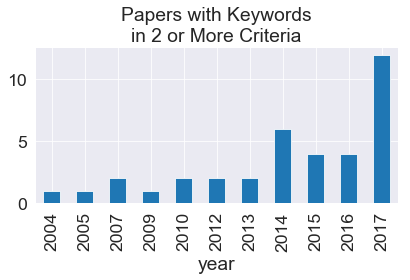

In [20]:
criteria_df = wosis.collate_keyword_criteria_matches(filtered_corpora, crit_matches)
wos_plot.plot_criteria_trend(criteria_df, threshold=2)

In [21]:
criteria_df.count()

abstract              13955
id                    13955
keywords              13955
title                 13955
year                  13955
num_criteria_match    13955
dtype: int64

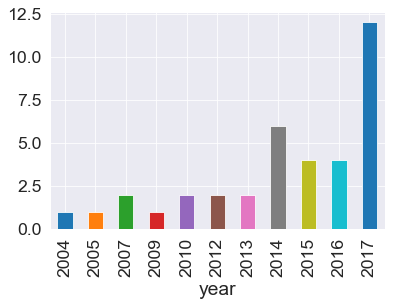

In [22]:
#want to view the papers in the above plot
crit_trend_tmp = criteria_df.loc[criteria_df['num_criteria_match'] > 1, ~criteria_df.columns.isin(hide_columns)]
#criteria_trend.loc[:, criteria_trend.columns.isin(hide_columns)].head(10)


crit_trend_tmp.groupby('year').count()['title'].plot(kind='bar')

In [23]:
crit_trend_tmp['title']

367      Quantitative global sensitivity analysis of th...
818      Sensitivity analysis of related parameters in ...
1192     Making the most out of a hydrological model da...
1431     Parameter Sensitivity of a Surface Water Quali...
1506     Necessary condition for applying experimental ...
2046     Sensitivity analysis of reference evapotranspi...
2096     Modelling the effects of water diversion and c...
2117     A non-probabilistic methodology for reliable s...
2172     Developing a robust assessment system for the ...
4001     Three complementary methods for sensitivity an...
4640     Evaluating the Use of Global Sensitivity Analy...
4650     A successive steady-state model for simulating...
6108     Assessing greenhouse gas emissions of milk pro...
6129     The use of global sensitivity analysis for imp...
6886     Distributed Evaluation of Local Sensitivity An...
7550     Global sensitivity analysis: A flexible and ef...
8324     Predicting the fate of micropollutants during .

In [24]:
# ?wosis.keyword_matches

In [25]:
lsa_matches = wosis.keyword_matches(filtered_corpora, criteria['LSA'], threshold=95.0)
gsa_matches = wosis.keyword_matches(filtered_corpora, criteria['GSA'], threshold=95.0)
oat_matches = wosis.keyword_matches(filtered_corpora, criteria['OAT'], threshold=95.0)

In [26]:
lsa_collated = lsa_matches.combine_recs()
lsa_df = wosis.rc_to_df(lsa_collated)

gsa_collated = gsa_matches.combine_recs()
gsa_df = wosis.rc_to_df(gsa_collated)

oat_collated = oat_matches.combine_recs()
oat_df = wosis.rc_to_df(oat_collated)

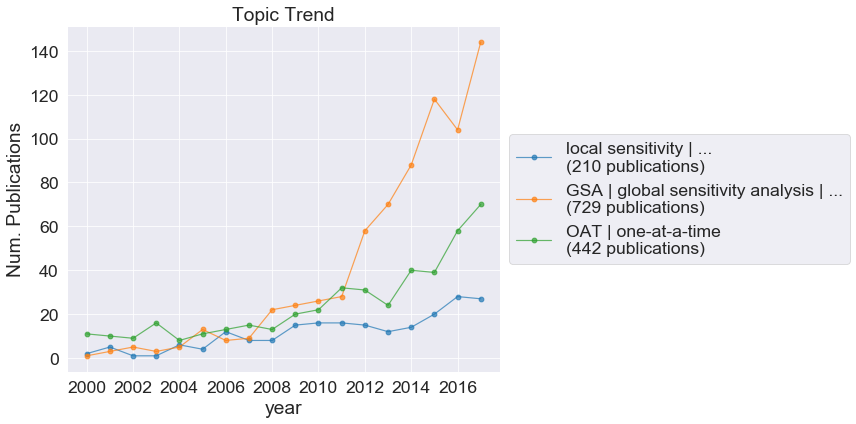

In [27]:
wos_plot.plot_topic_trend([lsa_matches, gsa_matches, oat_matches])